# Some Music Statistics

В проекте показаны различные примеры сбора некоторых статистических данных с использованием API портала Last.fm.
Полученные данные при необходимости сводятся в таблицы, выводятся диаграммы.

Данный проект является своего рода "курсовым проектом", закрепляющим мои начальные навыки в использовании средств сбора и обработки данных.

Цель проекта: выяснить, что предпочитают слушать пользователи портала last.fm. Так как проект "игрушечный", то практическую пользу от этого исследования выявлять не требуется.

## Шаг 1. Определение наиболее популярных жанров

Изучив документацию API, я выполнил стандартные шаги по регистрации своего приложения. Теперь создадим функцию для упрощения дальнейших запросов. 

In [1]:
import requests
import json
from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
def getRequests(method, params=''):
    api_key = '...'
    url = 'http://ws.audioscrobbler.com/2.0/?method={}&api_key={}&format=json'.format(method, api_key) + params
    getting_data = requests.get(url)
    getting_text = json.loads(getting_data.text)
    return getting_text

Запрос наиболее популярных жанров осуществляется через передачу следующего метода:

In [3]:
topTags = getRequests('tag.getTopTags')

Запрос возвращает словарь, где определяющими параметрами будет количество треков с жанром - 'count',
и охват аудитории - 'reach'. Выделять отдельную таблицу под эти параметры нет смысла, поэтому сохраняем эти параметры в одном списке, но параллельно создаем дополнительный список из названий жанров для простоты построения лейблов диаграмм.

Сортировать и предобрабатывать эти данные нет необходимости, так как они уже отсортированы по запросу и пропусков значений нет.

In [4]:
tags = []
genres = []
for element in topTags['toptags']['tag']: # Наименования лишних ключей.
        tags.append((element['name'],
                       element['count'], element['reach']))
        genres.append(element['name'].replace(' ', '\n')) # Перенос строки для более удобного представления на диаграмме.

Можно приступать к построению диаграмм. Выведем столбчатую диаграмму для 10 наиболее популярных жанров.

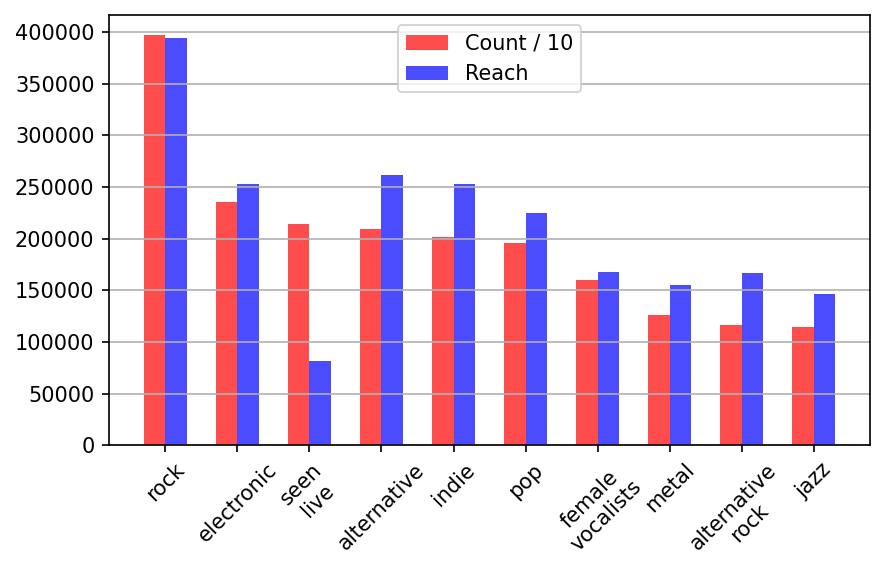

In [5]:
fig1, ax1 = plt.subplots(dpi = 150)
plt.title('Top Genres')
plt.axes().yaxis.grid(True, zorder = 1)
plt.bar([x for x in range(10)], [y[1] // 10 for y in tags[:10]], width = 0.3, # Делим на 10, так как слишком большие значения.
        color = 'red', alpha = 0.7, label = 'Count / 10')
plt.bar([x + 0.3 for x in range(10)], [y[2] for y in tags[:10]], width = 0.3,
        color = 'blue', alpha = 0.7, label = 'Reach')

grids = [float(x) + 0.15 for x in range(10)] # Данная линейка оси х только для красоты.

plt.xticks(grids, genres[:10], rotation = 45)
plt.tight_layout()
plt.legend(loc='upper center')
fig1.savefig('TopTags.png')

Можно заметить, что несколько выбивается подавляющая популярность рок-музыки. Проанализируем это позже. Так же выбиваетсяя некий жанр 'seen live'(видел вживую). При большом количестве песен этого жанра, слишком малый охват. Можно сделать вывод о том, что каждой песне назначается несколько тегов/жанров, а значит определяющим параметром в дальнейшем будет охват. Тем не менее, охват рок-музыки все равно преобладает.

Построим круговую диаграмму для большей наглядности, предварительно избавашись от "мусорного" жанра 'seen live'.

In [6]:
tags.sort(key = lambda x: x[2], reverse = True) # Сортируем по охвату.
reach_tags = [x[2] for x in tags[:10]]
genres = [x[0] for x in tags[:10]]

<Figure size 432x288 with 0 Axes>

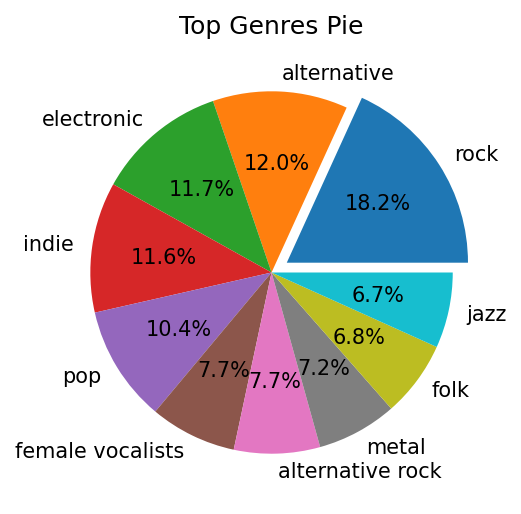

In [7]:
plt.clf()
fig2, ax2 = plt.subplots(dpi = 150)
plt.title('Top Genres Pie')
plt.pie(reach_tags, autopct = '%1.1f%%', explode = [0.1] + [0 for _ in range(9)],
       labels = genres[:10])
fig2.savefig('TopTagsPie.png')

Картина не изменилась и по-прежнему удивляет, почему жанр "поп" гораздо менее популярен, чем жанр "рок"?

Предположим, что такая популярность объясняется более обширной базой рок-песен, представленных на портале. Продолжим исследование и запросим топ жанров за неделю.

Данный запрос возвращает те же параметры, хотя и 'count' превратилась в 'taggings'.
Запрос без дополнительного параметра и вывод на экран позволяет определить количество страниц, для которых представляются данные. Попробуем обратиться к первой и последней странице, чтобы убедиться, что топ жанров не меняется.

In [8]:
topChartTags = getRequests('chart.gettoptags', '&page=1')
for i in range(10):
    print(topChartTags['tags']['tag'][i])

{'name': 'rock', 'url': 'https://www.last.fm/tag/rock', 'reach': '394795', 'taggings': '3968168', 'streamable': '1', 'wiki': {}}
{'name': 'electronic', 'url': 'https://www.last.fm/tag/electronic', 'reach': '253213', 'taggings': '2357570', 'streamable': '1', 'wiki': {}}
{'name': 'seen live', 'url': 'https://www.last.fm/tag/seen+live', 'reach': '81692', 'taggings': '2138542', 'streamable': '1', 'wiki': {}}
{'name': 'alternative', 'url': 'https://www.last.fm/tag/alternative', 'reach': '261253', 'taggings': '2092075', 'streamable': '1', 'wiki': {}}
{'name': 'indie', 'url': 'https://www.last.fm/tag/indie', 'reach': '252711', 'taggings': '2012545', 'streamable': '1', 'wiki': {}}
{'name': 'pop', 'url': 'https://www.last.fm/tag/pop', 'reach': '224859', 'taggings': '1961160', 'streamable': '1', 'wiki': {}}
{'name': 'female vocalists', 'url': 'https://www.last.fm/tag/female+vocalists', 'reach': '167705', 'taggings': '1595331', 'streamable': '1', 'wiki': {}}
{'name': 'metal', 'url': 'https://www.

In [9]:
topChartTags = getRequests('chart.gettoptags', '&page=54320')
for i in range(10):
    print(topChartTags['tags']['tag'][i])

{'name': 'rock', 'url': 'https://www.last.fm/tag/rock', 'reach': '394846', 'taggings': '3968973', 'streamable': '1', 'wiki': {}}
{'name': 'electronic', 'url': 'https://www.last.fm/tag/electronic', 'reach': '253260', 'taggings': '2358739', 'streamable': '1', 'wiki': {}}
{'name': 'seen live', 'url': 'https://www.last.fm/tag/seen+live', 'reach': '81692', 'taggings': '2139343', 'streamable': '1', 'wiki': {}}
{'name': 'alternative', 'url': 'https://www.last.fm/tag/alternative', 'reach': '261278', 'taggings': '2093963', 'streamable': '1', 'wiki': {}}
{'name': 'indie', 'url': 'https://www.last.fm/tag/indie', 'reach': '252768', 'taggings': '2014038', 'streamable': '1', 'wiki': {}}
{'name': 'pop', 'url': 'https://www.last.fm/tag/pop', 'reach': '224913', 'taggings': '1966504', 'streamable': '1', 'wiki': {}}
{'name': 'female vocalists', 'url': 'https://www.last.fm/tag/female+vocalists', 'reach': '167711', 'taggings': '1599465', 'streamable': '1', 'wiki': {}}
{'name': 'metal', 'url': 'https://www.

Цифры и позиции в топе практически не меняются, более того, они также практически не отличаются от полученного первым запросом списка. Можно сделать вывод, что или я, или, возможно, программисты сайта что-то не учли. В любом случае, придется менять стратегию исследования и обратимся к другим запросам.

## Шаг 2. Определение популярных жанров по трекам

Выполним запрос по наиболее популярным трекам

In [10]:
TopChartTracks = getRequests('chart.getTopTracks') # Total pages 482104.

Этот запрос дает актуальную и достаточно обширную информацию для составления таблицы, хотя жанр и не выводится в тексте.
(Я осознаю, что для хранения 50 элементов и работы с ними csv таблица и не нужна, можно было на основе списков сразу составить DataFrame, но данный проект нужен для того, чтобы я мог закрепить свои навыки работы с разными инсрументами)

In [11]:
headers = ['track_name', 'artist_name', 'playcount', 'listeners', 'genre_name']
TopTracksCSV = 'TopTracksCSV.csv'
with open (TopTracksCSV, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

In [12]:
with open (TopTracksCSV, 'a', encoding='utf-8') as file:
    writer = csv.writer(file)
    for element in TopChartTracks['tracks']['track']:
        writer.writerow([element['name'], element['artist']['name'], element['playcount'], element['listeners'], 'unknow'])

Для простоты работы, далее будем работать с pandas.
Проверим задно необходимость предобработки данных, сравнив количество нулевых данных в таблице. 

In [13]:
df = pd.read_csv('TopTracksCSV.csv')
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
track_name     50 non-null object
artist_name    50 non-null object
playcount      50 non-null int64
listeners      50 non-null int64
genre_name     50 non-null object
dtypes: int64(2), object(3)
memory usage: 1.4+ KB


(50, 5)

Нулевых данных нет. Запросим жанры для каждого исполнителя и добавим их. Предварительно посмотрев, что нам дает запрос getTopTags, выяснилось, что, как и предполагалось, каждому треку задается несколько тегов/жанров (интересно почитать о некоторых направлениях музыки, например, у Kanye West в числе прочих значится тег bullshit). Тогда добавим в таблицу только первый, самый популярный жанр. Так же разумно добавлять имена артистов в словарь и перед запросом с ним сверяться, чтобы не запрашивать для одного и того же артиста теги по несколько раз. 

*Небольшая хитрость, в словаре каждому артисту присвается значение строки первого вхождения, с целью обращения к конкретной ячейке таблицы в блоке else и автоматического заполнения жанра для повторяющихся артистов

In [14]:
dict_for_artist = {}
for i in range(50):
    artist = df.loc[i, 'artist_name']
    if artist not in dict_for_artist:
        dict_for_artist[artist] = i
        artistGetTags = getRequests('artist.getTopTags', '&artist={}'.format(artist.replace(' ', '+')))
        if artistGetTags['toptags']['tag']:
            new_value = artistGetTags['toptags']['tag'][0]['name']
            df.loc[i, 'genre_name'] = new_value
    else:
        extract = df.loc[int(dict_for_artist[artist]), 'genre_name']
        df.loc[i, 'genre_name'] = extract
df.head(12)

,track_name,artist_name,playcount,listeners,genre_name
0,Follow God,Kanye West,1063444,158095,Hip-Hop
1,Selah,Kanye West,679300,131985,Hip-Hop
2,Closed On Sunday,Kanye West,640518,127360,Hip-Hop
3,On God,Kanye West,663463,124504,Hip-Hop
4,Every Hour,Kanye West,444716,116784,Hip-Hop
5,Everything We Need,Kanye West,510984,109601,Hip-Hop
6,bad guy,Billie Eilish,4504955,374134,pop
7,God Is,Kanye West,503531,104919,Hip-Hop
8,Water,Kanye West,419437,100341,Hip-Hop
9,Jesus Is Lord,Kanye West,386348,99246,Hip-Hop


Сразу небольшое уточнение. Пришлось сделать условие для вывода запроса, потому что при некоторых других запросах(например, при запросе жанра по треку, а не артисту, таков был первый вариант) я получал ошибку. Это было связано с тем, что в 29 треке (определил я это с помощью алгоритма "разделяй и властвуй", если интересно) в наименовании стояли не валидные символы. Так же, по некоторым запросам теги были пустые.

Просмотр таблицы, в целом показывает, что дальнейшая обработка не требуется, но при больших объемах, естесственно, необходимо избавиться от пустых или нерелевантных строк. 

In [15]:
df = df[df.genre_name != 'unknow']
df.shape

(50, 5)

Размер таблицы не изменился, нулевые значения исключены еще на этабе сбора информации. Можно приступать к усреднению показателей и выводу диаграмм.

In [16]:
genre_data = df.groupby('genre_name')
mean_playcount = genre_data['playcount'].mean()
mean_listeners = genre_data['listeners'].mean()
new_genres = [x[0] for x in genre_data]

In [17]:
for i in range(len(new_genres)):
    new_genres[i] = new_genres[i].replace(' ', '\n')

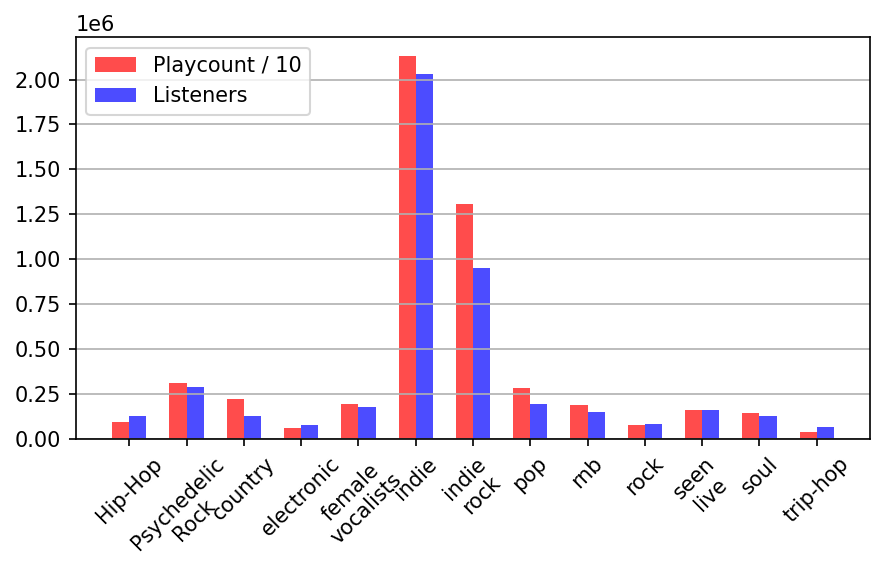

In [18]:
plt.clf
fig3, ax3 = plt.subplots(dpi = 150)
plt.title('Top Genres in Chart')
plt.axes().yaxis.grid(True, zorder = 1)
plt.bar([x for x in range(len(new_genres))], [y //10 for y in mean_playcount], width = 0.3,
        color = 'red', alpha = 0.7, label = 'Playcount / 10')
plt.bar([x + 0.3 for x in range(len(new_genres))], [y for y in mean_listeners], width = 0.3,
        color = 'blue', alpha = 0.7, label = 'Listeners')

grids = [float(x) + 0.15 for x in range(len(new_genres))]

plt.xticks(grids, new_genres, rotation = 45)
plt.tight_layout()
plt.legend(loc='upper left')
fig3.savefig('TopTagsChart.png')

Результат удивляет. Во-первых, ожидалась популярность совсем другого жанра, учитывая, что на всех первых строках чарта стоит все же Kanye West. При этом огромная популярность инди и инди-рока вообще похожа на выброс данных. Посмотрим показатели в таблице.

In [19]:
print(df[df['genre_name'] == 'indie'])
print(df[df['genre_name'] == 'indie rock'])

        track_name  artist_name  playcount  listeners genre_name
45  Mr. Brightside  The Killers   21291705    2031304      indie
          track_name     artist_name  playcount  listeners  genre_name
46  Do I Wanna Know?  Arctic Monkeys   13099357     950860  indie rock


21 и 13 миллионов прослушиваний, данные верны, но The Killers и Arctic Monkeys все равно на 45 и 46 месте в чарте. Почему так - достоверно неясно. Но зато теперь ясно, почему в 1-м шаге была огромная популярность рок-музыки. Очевидно, в тегах этих исполнителей, присутствует и тег "рок". Предположим, что так как песня Arctic Monkeys вышла в 2013 году, а песня The Killers вообще в далеком 2003, то огромный охват объясняется не менее огромной фан-базой, что не позволяет этим уже немолодым песням вылетать из чартов и позволяет делать охват всей рок-музыке. В таком случае, есть смысл выяснить, чем обусловлены первые места чартов. Проследим динамику изменения популярности исполнителя, занявшего первые строки.

In [20]:
headers = ['track_name', 'artist_name', 'playcount', 'listeners']
PopularCSV = 'PopularCSV.csv'
with open (PopularCSV, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
with open (PopularCSV, 'a', encoding='utf-8') as file:
    writer = csv.writer(file)
    for i in range(1, 11):
        most_popular = getRequests('chart.gettoptracks', '&page={}'.format(i))
        for element in most_popular['tracks']['track']:
            if element['artist']['name'] == 'Kanye West':
                writer.writerow([element['name'], element['artist']['name'], element['playcount'], element['listeners']])
                break

In [21]:
popDF = pd.read_csv(PopularCSV)
popDF.head(10)

,track_name,artist_name,playcount,listeners
0,Follow God,Kanye West,1063444,158095
1,Power,Kanye West,5903703,689172
2,Black Skinhead,Kanye West,4489309,499684
3,All of the Lights,Kanye West,5948706,756981
4,Ghost Town,Kanye West,1549264,129022
5,Gold Digger,Kanye West,3249842,650905
6,Dark Fantasy,Kanye West,3854214,535944
7,Ghost Town,Kanye West,1549264,129022
8,No More Parties In LA,Kanye West,1126658,150385
9,Follow God,Kanye West,1063444,158095


Мы создали новую таблицу, в которую заносили информацию только об одном артисте в течение последних 10 чартов и только по самому популярному треку. Теперь можем построить график, чтобы наглядно проследить динамику роста популярности.

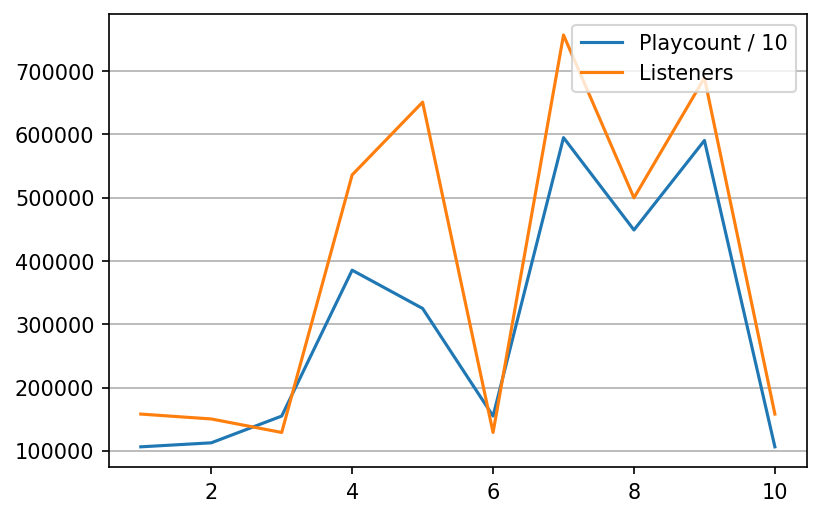

In [22]:
plt.clf
fig4, ax4 = plt.subplots(dpi = 150)
plt.title('Kanye West in dynamics')
plt.xlabel('Charts')
plt.axes().yaxis.grid(True, zorder = 1)
chart = [x for x in range(1, 11)]
plt.plot(chart, popDF.loc[9:0:-1, 'playcount'] // 10, linestyle = 'solid', label = 'Playcount / 10')
plt.plot(chart, popDF.loc[9:0:-1, 'listeners'], linestyle = 'solid', label = 'Listeners')
plt.legend(loc='upper right')
fig4.savefig('Kanye West in dynamics.png')

Интересная картина. Мы явно видим взрывной рост популярности артиста начавшийся примерно 7 недель назад (сейчас 23.11.2019), резкий спад на 5 неделе и снова подъем на 6-й. Странное поведение, которое, оказывается, объяснимо, если почитать прессу. Во временной промежуток, соответствующеий 6-й неделе, выходил новый альбом этого исполнителя, который, как понимаю, был перенесен не один раз, что подогревало интерес и ранее. Остаются пока непонятными 2 вещи: резкий спад в данный момент (неужели мы как раз на моменте реального спада интереса?) и почему треки из еще не вышедшего альбома оказались в чарте 10-недельной давности (по википедии: "По данным сайта TechCrunch, сайт «Last.fm» передаёт ассоциации RIAA информацию о пользователях, слушающих альбомы до их официального выхода"). Второе, впрочем, может объяснятся и корявой функциональностью запросов, в чем мы уже убедились.

# Вывод

Так или иначе, мы можем сделать вывод о том, что актуальная популярность исполнителя на портале last.fm обуславливается не абсолютным или усредненным количеством прослушиваний, а скоростью роста этих прослушиваний. А значит, первые места, несмотря на колоссальный слушательский бэкграунд рок-музыки, всегда принадлежат тем, кто в тренде. Вывод очевидный, хотя первые цифры и говорили об обратном.